In [67]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

from matplotlib.pyplot import imshow
import numpy as np
import random
import torch.multiprocessing as mp

from torch.multiprocessing import Pool, Process, set_start_method

import os

In [146]:
'''
This code is adapted from two sources:
(i) The official PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py)
(ii) Starter code from Yisong Yue's CS 155 Course (http://www.yisongyue.com/courses/cs155/2020_winter/)
'''

class fcNet(nn.Module):
    '''
    Design your model with fully connected layers (convolutional layers are not
    allowed here). Initial model is designed to have a poor performance. These
    are the sample units you can try:
        Linear, Dropout, activation layers (ReLU, softmax)
    '''
    def __init__(self):
        # Define the units that you will use in your model
        # Note that this has nothing to do with the order in which operations
        # are applied - that is defined in the forward function below.
        super(fcNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=20)
        self.fc2 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Define the sequence of operations your model will apply to an input x
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output


class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        # Layers available: Linear, Conv2d, MaxPool2d, AvgPool2d, ReLU, Softmax, BatchNorm2d, Dropout, Flatten
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(8, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.1)
        self.dropout2 = nn.Dropout2d(0.1)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [178]:
def train(args, model, device, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num,
        100. * correct / test_num))
    return test_loss, 100. * correct / test_num

# Training settings
# Use the command line to modify the default settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--step', type=int, default=1, metavar='N',
                    help='number of epochs between learning rate reductions (default: 1)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--evaluate', action='store_true', default=False,
                    help='evaluate your model on the official test set')
parser.add_argument('--load-model', type=str,
                    help='model file path')

parser.add_argument('--save-model', action='store_true', default=True,
                    help='For Saving the current Model')
args = parser.parse_args(["--lr", "1", "--epochs", "3", "--batch-size", "128", "--log-interval", "20"])

In [148]:
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Evaluate on the official test set
if args.evaluate:
    assert os.path.exists(args.load_model)

    # Set the test model
    model = fcNet().to(device)
    model.load_state_dict(torch.load(args.load_model))

    test_dataset = datasets.MNIST('../data', train=False,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                ]))

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

    test(model, device, test_loader)
    # return # TODO: UNCOMMENT

In [149]:
# Pytorch has default MNIST dataloader which loads data at each iteration
train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([       # Data preprocessing
                #transforms.RandomAffine(degrees=[-10, 10], scale=[0.95, 1.05],
                #                        shear=[-5, 5, -5, 5]),
                transforms.RandomResizedCrop(28, scale=(0.9, 1)),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                transforms.ToTensor(),           # Add data augmentation here
                transforms.Normalize((0.1307,), (0.3081,))
            ]))# Pytorch has default MNIST dataloader which loads data at each iteration
valid_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([       # Data preprocessing
                transforms.ToTensor(),           # Add data augmentation here
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

In [150]:
# imshow(train_dataset[2][0].squeeze(0))

In [151]:
labels_file = 'train_class_labels.npy'
if os.path.exists(labels_file):
    train_classes = np.load('train_class_labels.npy')
else:
    train_classes = [train_dataset[i][1] for i in range(len(train_dataset))]
    np.save('train_class_labels.npy', np.array(train_classes, dtype=int))

In [152]:
ind_by_classes = {}
for i, train_class in enumerate(train_classes):
    if train_class not in ind_by_classes:
        ind_by_classes[train_class] = []
    ind_by_classes[train_class].append(i)

In [184]:
random.seed(args.seed)

# You can assign indices for training/validation or use a random subset for
# training by using SubsetRandomSampler. Right now the train and validation
# sets are built from the same indices - this is bad! Change it so that
# the training and validation sets are disjoint and have the correct relative sizes.
subset_indices_train = []
subset_indices_valid = []
percent_train = 0.85
reduction_factor = 1/2

for class_id in sorted(ind_by_classes.keys()):
    class_inds = ind_by_classes[class_id]
    n_train = int(len(class_inds) * percent_train)
    train_class_inds = random.sample(class_inds, n_train)
    reduced_train_class_inds = random.sample(
        train_class_inds, int(n_train * reduction_factor)
    )
    valid_class_inds = set(class_inds).difference(set(train_class_inds))
    print("For class:", class_id,"there are", len(reduced_train_class_inds),
          "train and", len(valid_class_inds), "valid")
    subset_indices_train.extend(reduced_train_class_inds)
    subset_indices_valid.extend(valid_class_inds)

For class: 0 there are 2517 train and 889 valid
For class: 1 there are 2865 train and 1012 valid
For class: 2 there are 2532 train and 894 valid
For class: 3 there are 2605 train and 920 valid
For class: 4 there are 2482 train and 877 valid
For class: 5 there are 2303 train and 814 valid
For class: 6 there are 2515 train and 888 valid
For class: 7 there are 2662 train and 940 valid
For class: 8 there are 2486 train and 878 valid
For class: 9 there are 2528 train and 893 valid


In [185]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=args.test_batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

# Load your model [fcNet, ConvNet, Net]
model = Net().to(device)
processes = []

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

In [186]:
#### Training loop
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)
    scheduler.step()    # learning rate scheduler
    # You may optionally save your model at each epoch here

if args.save_model:
    torch.save(model.state_dict(), "mnist_model.pt")

Train Epoch: 1 [0/25495 (0%)]	Loss: 2.311973
Train Epoch: 1 [2560/25495 (10%)]	Loss: 1.019235
Train Epoch: 1 [5120/25495 (20%)]	Loss: 0.289740
Train Epoch: 1 [7680/25495 (30%)]	Loss: 0.301569
Train Epoch: 1 [10240/25495 (40%)]	Loss: 0.297787
Train Epoch: 1 [12800/25495 (50%)]	Loss: 0.197427
Train Epoch: 1 [15360/25495 (60%)]	Loss: 0.195266
Train Epoch: 1 [17920/25495 (70%)]	Loss: 0.159076
Train Epoch: 1 [20480/25495 (80%)]	Loss: 0.214325
Train Epoch: 1 [23040/25495 (90%)]	Loss: 0.236677

Test set: Average loss: 0.1126, Accuracy: 8694/9005 (97%)

Train Epoch: 2 [0/25495 (0%)]	Loss: 0.107155
Train Epoch: 2 [2560/25495 (10%)]	Loss: 0.106728
Train Epoch: 2 [5120/25495 (20%)]	Loss: 0.160613
Train Epoch: 2 [7680/25495 (30%)]	Loss: 0.087971
Train Epoch: 2 [10240/25495 (40%)]	Loss: 0.212868
Train Epoch: 2 [12800/25495 (50%)]	Loss: 0.113170
Train Epoch: 2 [15360/25495 (60%)]	Loss: 0.074584
Train Epoch: 2 [17920/25495 (70%)]	Loss: 0.254798
Train Epoch: 2 [20480/25495 (80%)]	Loss: 0.142224
Train 

In [187]:
#### Training loop
for epoch in range(args.epochs + 1, 2 * args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)
    scheduler.step()    # learning rate scheduler
    # You may optionally save your model at each epoch here

if args.save_model:
    torch.save(model.state_dict(), "mnist_model.pt")

Train Epoch: 4 [0/25495 (0%)]	Loss: 0.064149
Train Epoch: 4 [2560/25495 (10%)]	Loss: 0.085195
Train Epoch: 4 [5120/25495 (20%)]	Loss: 0.077603
Train Epoch: 4 [7680/25495 (30%)]	Loss: 0.038851
Train Epoch: 4 [10240/25495 (40%)]	Loss: 0.109839
Train Epoch: 4 [12800/25495 (50%)]	Loss: 0.065123
Train Epoch: 4 [15360/25495 (60%)]	Loss: 0.036100
Train Epoch: 4 [17920/25495 (70%)]	Loss: 0.053687
Train Epoch: 4 [20480/25495 (80%)]	Loss: 0.015201
Train Epoch: 4 [23040/25495 (90%)]	Loss: 0.093991

Test set: Average loss: 0.0435, Accuracy: 8882/9005 (99%)

Train Epoch: 5 [0/25495 (0%)]	Loss: 0.091599
Train Epoch: 5 [2560/25495 (10%)]	Loss: 0.037657
Train Epoch: 5 [5120/25495 (20%)]	Loss: 0.066473
Train Epoch: 5 [7680/25495 (30%)]	Loss: 0.052212
Train Epoch: 5 [10240/25495 (40%)]	Loss: 0.110585
Train Epoch: 5 [12800/25495 (50%)]	Loss: 0.036681
Train Epoch: 5 [15360/25495 (60%)]	Loss: 0.017449
Train Epoch: 5 [17920/25495 (70%)]	Loss: 0.024416
Train Epoch: 5 [20480/25495 (80%)]	Loss: 0.068909
Train 

In [188]:
torch.save(model.state_dict(), "mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_2th_data.pt")

In [177]:
test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)



Test set: Average loss: 0.0485, Accuracy: 9839/10000 (98%)



In [183]:
model_file = 'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_half_data.pt'
model = Net().to(device)
model.load_state_dict(torch.load(model_file))
test(model, device, train_loader)  


Test set: Average loss: 0.2136, Accuracy: 12460/12745 (98%)



(0.2136283663498649, 97.7638289525304)

In [181]:
scores = np.zeros((len(model_files), 3))
loaders = [train_loader, val_loader, test_loader]
model_files = [
    'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_1th_data.pt',
    'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_2th_data.pt',
    'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_4th_data.pt',
    'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_8th_data.pt',
    'mnist_model_1_lr_128_batch_prepped_01_drop_32_filt_128_hu_6_epochs_16th_data.pt'
]

In [189]:
for i, model_file in enumerate(model_files):
    if i != 1:
        continue
    model = Net().to(device)
    model.load_state_dict(torch.load(model_file))
    for j, loader in enumerate(loaders):
        loss, accuracy = test(model, device, loader)
        scores[i, j] = loss


Test set: Average loss: 0.0507, Accuracy: 12552/12745 (98%)


Test set: Average loss: 0.0381, Accuracy: 8899/9005 (99%)


Test set: Average loss: 0.0336, Accuracy: 9881/10000 (99%)



In [190]:
scores

array([[0.02924621, 0.02198856, 0.02520487],
       [0.05072586, 0.0381471 , 0.03364448],
       [0.05845686, 0.06241949, 0.04850108],
       [0.11783978, 0.09273344, 0.07750114],
       [0.22486474, 0.18427042, 0.16235153]])

In [206]:
import seaborn as sns
import pandas as pd
loss_df = pd.DataFrame(scores, columns=['train', 'valid', 'test'],
                       index=[1, 2, 4, 8, 16])
loss_df = loss_df.reset_index()

In [216]:
loss_df['Data train on (%)'] = 1/loss_df['index']
loss_df['Data train on (log %)'] = np.log(loss_df['Data train on (%)'])
loss_df['Log train loss'] = np.log(loss_df['train'])
loss_df['Log valid loss'] = np.log(loss_df['valid'])
loss_df['Log test loss'] = np.log(loss_df['test'])

Text(0, 0.5, 'Log loss')

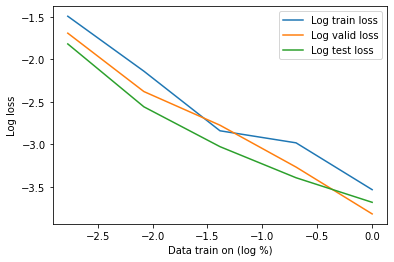

In [218]:
import matplotlib.pyplot as plt
loss_df.plot(x='Data train on (log %)',
             y=['Log train loss', 'Log valid loss', 'Log test loss'])
plt.ylabel('Log loss')
# sns.lineplot(
#     data=loss_df,
#     x='Data train on (log %)',
#     y=['test', 'valid']
# )
# .set(
#     xlabel='Percentage of data trained on', ylabel='Loss'
# )

In [392]:
def get_targets_preds(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    targets = []
    preds = []
    datas = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        #print(pred)
        #if len(targets) == 0 or len(targets[0]) == 0:
        #    continue
        #return targets
        datas.append(data)
        targets.append(target)
        preds.append(pred)
        #correct += pred.eq(target.view_as(pred)).sum().item()
        #test_num += len(data)
    return datas, targets, preds

def get_targets_easier(model, test_dataset):
    model.eval()    # Set the model to inference mode
    targets = []
    preds = []
    datas = []
    for i, [data, target] in enumerate(test_dataset):
        data = data.to(device)
        output = model(data.unsqueeze(0))
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        datas.append(data)
        targets.append(target)
        preds.append(pred)
    return datas, targets, preds

In [393]:
datas, targets, preds = get_targets_easier(model, test_dataset)

In [388]:
# datas, targets, preds = get_targets_preds(model, device, test_loader)

In [414]:
target_list = targets
pred_list = []
for tensor in preds:
    pred_list.extend(tensor.flatten().cpu().numpy().tolist())
datas_list = []
for tensor in datas:
    datas_list.extend(tensor.cpu().numpy())
"""
for tensor in targets:
    target_list.extend(tensor.cpu().numpy().tolist())
pred_list = []
for tensor in preds:
    pred_list.extend(tensor.flatten().cpu().numpy().tolist())
datas_list = []
for tensor in datas:
    datas_list.extend(tensor.cpu().numpy())
"""

'\nfor tensor in targets:\n    target_list.extend(tensor.cpu().numpy().tolist())\npred_list = []\nfor tensor in preds:\n    pred_list.extend(tensor.flatten().cpu().numpy().tolist())\ndatas_list = []\nfor tensor in datas:\n    datas_list.extend(tensor.cpu().numpy())\n'

In [417]:
is_corrects = [target_list[i] == pred_list[i] for i in range(len(target_list))] 
wrong_list = []
guessed_id = []
actual_id = []
wrong_inds = []
for i, status in enumerate(is_corrects):
    if status == False:
        wrong_list.append(datas_list[i])
        guessed_id.append(pred_list[i])
        actual_id.append(target_list[i])
        wrong_inds.append(i)
    if len(wrong_list) > 8:
        break

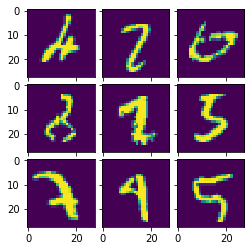

In [418]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, wrong_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [419]:
guessed_id, actual_id

([2, 7, 0, 2, 1, 3, 3, 9, 9], [4, 2, 6, 8, 2, 5, 7, 4, 5])

In [375]:
modules = [i for i in model.modules()]
conv1_parameters = [i for i in modules[1].parameters()]
conv1_weights = conv1_parameters[0]
weight_images = [weight.squeeze(0).squeeze(0).cpu().detach().numpy() for weight in conv1_weights]

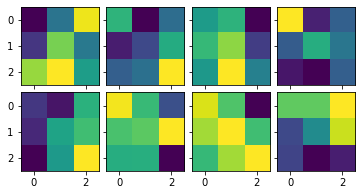

In [378]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, weight_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [297]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target_list, pred_list)

array([[ 975,    0,    0,    0,    0,    1,    2,    1,    1,    0],
       [   0, 1132,    0,    1,    0,    0,    1,    1,    0,    0],
       [   3,    3, 1021,    0,    0,    0,    0,    4,    1,    0],
       [   0,    0,    1, 1000,    0,    2,    0,    4,    2,    1],
       [   0,    0,    1,    0,  971,    0,    0,    1,    0,    9],
       [   1,    0,    0,    6,    0,  878,    2,    0,    1,    4],
       [   5,    2,    0,    0,    5,    4,  941,    0,    1,    0],
       [   0,    2,    2,    2,    0,    0,    0, 1013,    1,    8],
       [   1,    0,    1,    1,    1,    3,    1,    2,  961,    3],
       [   1,    3,    0,    3,    6,    2,    0,    3,    2,  989]])

In [302]:
global view_output
def hook_fn(module, input, output):
    global view_output
    view_output = output
hook = model.fc1.register_forward_hook(hook_fn)

In [320]:
vectors = np.empty((10000, 128))
gts = np.empty(10000)
for i in range(len(test_dataset)):
    model(test_dataset[i][0].unsqueeze(0).to(device))
    vectors[i] = view_output.cpu().detach().numpy()[0]
    gts[i] = test_dataset[i][1]

In [319]:
# With help from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [326]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.155s...
[t-SNE] Computed neighbors for 10000 samples in 15.953s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.914020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.234863
[t-SNE] KL divergence after 1000 iterations: 1.571522


In [331]:
tsne_df = pd.DataFrame(
    {
        'axis-1': tsne_results[:, 0],
        'axis-2': tsne_results[:, 1],
        'gt': gts
    }
)
tsne_df['gt'] = tsne_df['gt'].astype(int)

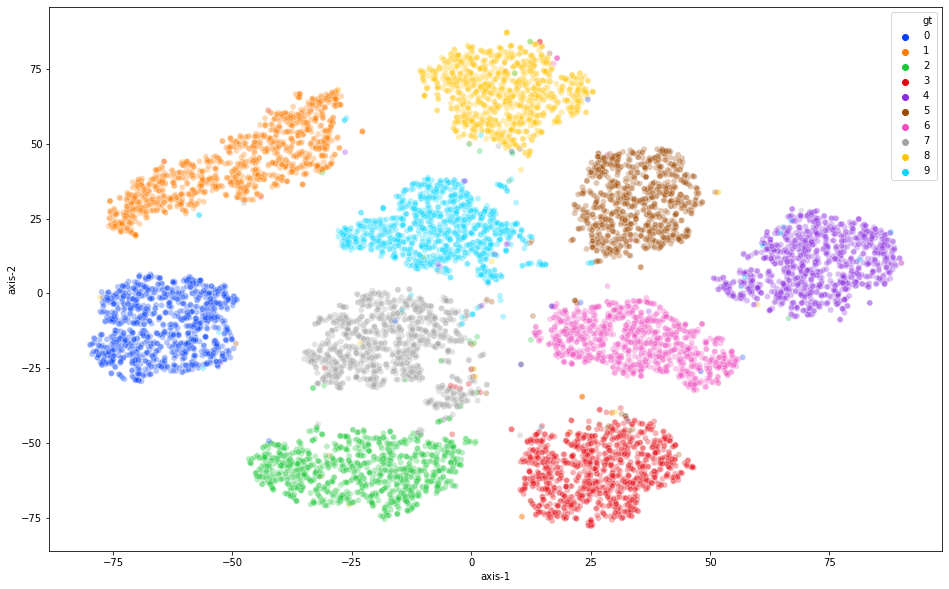

In [332]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="axis-1", y="axis-2",
    hue="gt",
    palette=sns.color_palette("bright", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [420]:
from sklearn.neighbors import KDTree
kdt = KDTree(vectors, leaf_size=30, metric='euclidean')
chosen_ones = [0, 69, 420, 6969] + wrong_inds[:4]
neighbours = kdt.query(vectors[chosen_ones], k=9, return_distance=False)

In [421]:
neighbours

array([[   0, 4800, 8815, 3400, 7632,  494, 9851, 9285, 7654],
       [  69, 9440, 4650, 8468, 4957, 7943, 5452,  269, 1944],
       [ 420, 1849, 1279, 5260, 6780, 9669, 8317, 3544, 7488],
       [6969, 8768, 7167, 8875, 5442, 7048, 8873, 8367, 6515],
       [ 247, 1549, 3941,  610, 9745, 3780,   43, 9981, 8353],
       [ 321, 3736, 3494, 1660, 7419, 4837, 8151, 1117, 9839],
       [ 445,  642, 9038, 4614, 5243, 1819, 5251, 1191, 5459],
       [ 582, 4135, 3207, 2911, 9613, 1538,  830, 2112, 4341]])

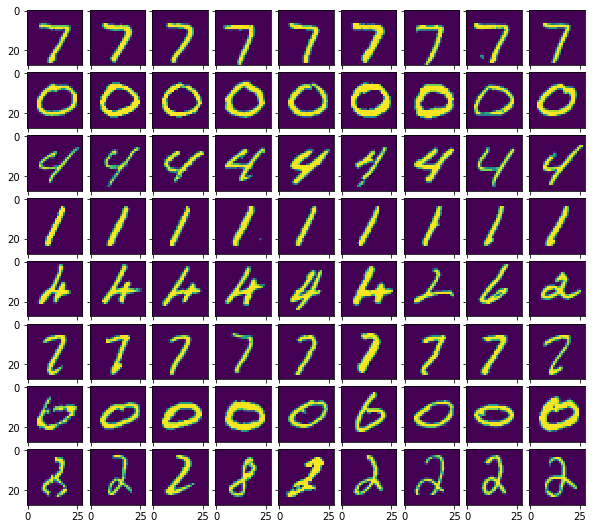

In [422]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(neighbours.shape[0], 9),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

the_hood = []
for i in neighbours.flatten():
    the_hood.append(test_dataset[i][0].squeeze(0))

for ax, im in zip(grid, the_hood):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()